# Mixtures of PPCA's
In this chapter, we introduce mixtures of PPCA models.

In [158]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
sns.set()

In [136]:
moppcas_model = pystan.StanModel(file='mopccas.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9c39844ad60ff1991d4662f6a506b770 NOW.


In [137]:
N=1000
M=2
D=3
K=4
mu = np.random.uniform(-50,50,size=(K,D))
sigma = np.random.uniform(0,3,size=(K))
while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break

z = []
W = []
for k in range(K):
    W.append(np.random.normal(0,1.5,size=(D,M)))
    z.append(np.random.normal(0,1, size=(M,N)))
    
x = np.zeros((N,D))
ind = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta)
    x[n,:] = np.random.normal(np.matmul(W[opt],z[opt][:,n])+mu[opt], sigma[opt])
    ind.append(opt)

print('theta: ', theta)
print()
for k in range(K):
    print('W_'+str(k)+':\n',W[k])
    print('mu_'+str(k)+': ',mu[k,:])
    print('sigma_'+str(k)+': ',sigma[k])
    print()

theta:  [0.22669497 0.14278726 0.22152629 0.40899148]

W_0:
 [[-0.28440974 -0.87472101]
 [ 0.05846564 -2.53698992]
 [-2.98336619  0.42657466]]
mu_0:  [11.34866485  4.70374224 48.33962533]
sigma_0:  0.27780491537516794

W_1:
 [[ 4.94044474 -2.72337413]
 [-2.06859921  0.92341935]
 [-1.09005769 -0.53380794]]
mu_1:  [ 42.60956391 -16.79050359  26.44670297]
sigma_1:  0.6684544821042797

W_2:
 [[0.66768153 0.49676641]
 [0.07801641 0.2719276 ]
 [1.13045615 1.32740596]]
mu_2:  [-15.5626034    1.23811177 -32.44775672]
sigma_2:  2.487021508405735

W_3:
 [[-0.11247822 -1.31848136]
 [-1.32754367 -0.59809352]
 [-2.25741821  1.2919068 ]]
mu_3:  [  5.34344422  44.12215537 -32.35685843]
sigma_3:  2.043289016902905



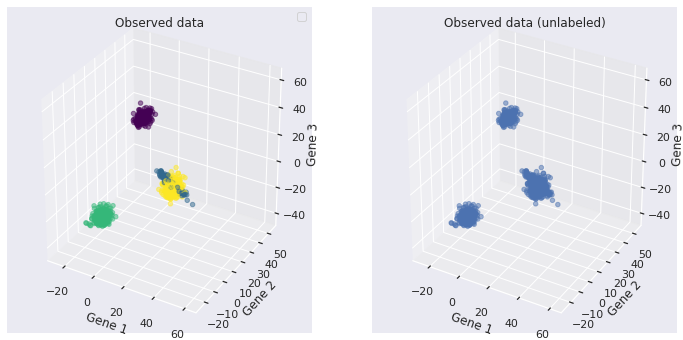

In [138]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis', alpha=0.5)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], cmap='viridis', alpha=0.5)
ax.set_title('Observed data (unlabeled)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

Since the optimization is highly dependend on the initial values, we initialize $\mu$ with a simple $k$-means clustering algorithm.

In [160]:
kmeans_init = KMeans(K).fit(x)

gmm_dat = {'N': N, 'M': M, 'K': K, 'D':D, 'y':x}
fit = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':kmeans_init.cluster_centers_}])
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [161]:
theta_sim = np.mean(fit_ext['theta'],axis=0)
mu_sim = np.mean(fit_ext['mu'],axis=0)
sigmas_sim = np.mean(fit_ext['sigma'],axis=0)
z_sim = fit_ext['z'][best_ind]
W_sim = np.mean(fit_ext['W'],axis=0)
clusters = np.mean(fit_ext['clusters'],axis=0)

order = True         # this tries to set the simulated clusters in the same order as the original; good for testing, but costly for real use
if order:
    mu_diffs = np.ones((K,K))
    for i in range(K):
        for j in range(K):
            mu_diffs[i,j] = sum([(mu[i][d]-mu_sim[j][d])**2 for d in range(D)])

    best_score = 10000
    for perm in list(itertools.permutations(list(range(K)))):
        score = 0
        for i,j in enumerate(perm):
            score+=mu_diffs[i,j]
        if score<best_score:
            best_order = perm
            best_score = score
    
    theta_sim = np.array([theta_sim[i] for i in best_order])
    mu_sim = np.array([mu_sim[i] for i in best_order])
    sigmas_sim = np.array([sigmas_sim[i] for i in best_order])
    z_sim = [z_sim[i] for i in best_order]
    W_sim = np.array([W_sim[i] for i in best_order])


print('Real theta: ',theta)
print('Sample theta: ',[sum(np.array(ind)==k)/N for k in range(K)])
print('Simulated theta: ',theta_sim)
print()
print('actual mu:\n',mu)
print('Simulated mu:\n',mu_sim)
print()
print('actual sigmas: ',sigma)
print('Simulated sigmas: ',sigmas_sim)
print()
for k in range(K):
    print('Actual WW^T_'+str(k)+': ')
    print(np.matmul(W[k],W[k].T))
    print('Simulated WW^T_'+str(k)+': ')
    print(np.matmul(W_sim[k],W_sim[k].T))
    print()

Real theta:  [0.22669497 0.14278726 0.22152629 0.40899148]
Sample theta:  [0.226, 0.152, 0.237, 0.385]
Simulated theta:  [0.22676703 0.15284735 0.23663442 0.3837512 ]

actual mu:
 [[ 11.34866485   4.70374224  48.33962533]
 [ 42.60956391 -16.79050359  26.44670297]
 [-15.5626034    1.23811177 -32.44775672]
 [  5.34344422  44.12215537 -32.35685843]]
Simulated mu:
 [[ 11.26060727   4.50030932  48.21852146]
 [ 43.17390746 -17.05571985  26.32113315]
 [-15.40233113   1.11324331 -32.19705868]
 [  5.25143536  44.10328214 -32.13497471]]

actual sigmas:  [0.27780492 0.66845448 2.48702151 2.04328902]
Simulated sigmas:  [0.08657932 0.36464895 4.88559564 3.69984717]

Actual WW^T_0: 
[[ 0.84602574  2.20253018  0.47536458]
 [ 2.20253018  6.43973611 -1.25664003]
 [ 0.47536458 -1.25664003  9.08243977]]
Simulated WW^T_0: 
[[ 0.67484033  1.79806913  0.19363907]
 [ 1.79806913  5.40552692 -1.65390759]
 [ 0.19363907 -1.65390759  7.71513803]]

Actual WW^T_1: 
[[ 31.82476086 -12.73461645  -3.93161104]
 [-12.73

In [162]:
# debug check for mixture cmponents analysis
# clusters = np.zeros((N,K))
# for n in range (N):
#     for k in range(K):
#         clusters[n,k] += np.log(theta_sim[k])
#         clusters[n,k] += multivariate_normal.logpdf(x[n,:], np.matmul(W_sim[k],z_sim[k][:,n])+mu_sim[k], sigmas_sim[k])

In [170]:
clusters_norm = (np.exp(clusters).T/sum(np.exp(clusters).T)).T                

In [164]:
z_cats = []
for n in range(N):
    for k in range(K):
        if clusters[n,k] == max(clusters[n,:]):
            z_cats.append(k)
            break

In [165]:
x_rec = np.zeros((N,D))
ind_rec = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta_sim)
    x_rec[n,:] = np.random.normal(np.matmul(W_sim[opt],z_sim[opt][:,n])+mu_sim[opt], sigmas_sim[opt])
    ind_rec.append(opt)

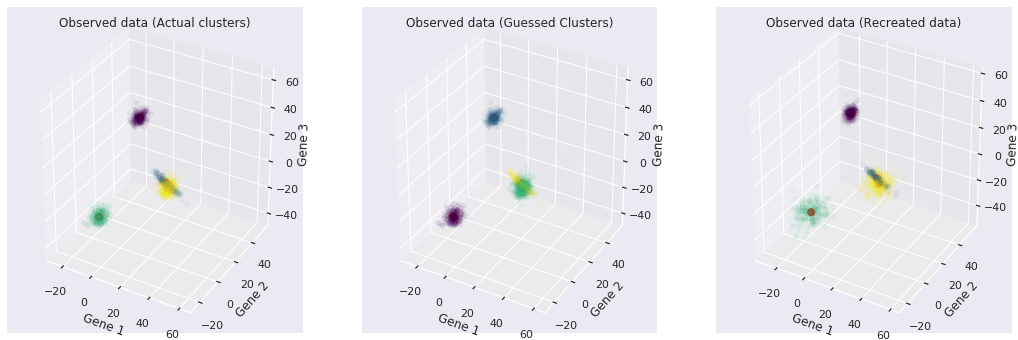

In [166]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=ind, cmap='viridis', alpha=0.05)
ax.scatter(mu[:,0],mu[:,1],mu[:,2], c='red', s=50, zorder=2, alpha=1)
ax.set_title('Observed data (Actual clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=z_cats, cmap='viridis', alpha=0.05,zorder=1)
ax.scatter(mu_sim[:,0],mu_sim[:,1],mu_sim[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Guessed Clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_rec[:,0],x_rec[:,1],x_rec[:,2],c=ind_rec, cmap='viridis', alpha=0.05, zorder=1)
ax.scatter(mu_sim[:,0],mu_sim[:,1],mu_sim[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Recreated data)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

The red dots in the above plot illustrate the real (left figure) and estimated (centre and right figure) values of $\mu$. (They are not always perfectly visible though, sorry for the inconvenience.)

In [167]:
for k in range(K):
    print('Actual mean of latent cluster '+str(k), np.mean(z[k],axis=1))
    print('Actual std. dev of latent cluster '+str(k), np.std(z[k],axis=1))
    print('Estimated mean of latent cluster '+str(k), np.mean(z_sim[k],axis=1))
    print('Estimated std. dev of latent cluster '+str(k), np.std(z_sim[k],axis=1))
    print()

Actual mean of latent cluster 0 [0.04604505 0.04247863]
Actual std. dev of latent cluster 0 [1.00358156 1.03167376]
Estimated mean of latent cluster 0 [-0.00630842 -0.02449095]
Estimated std. dev of latent cluster 0 [0.98038535 0.96512458]

Actual mean of latent cluster 1 [0.01944575 0.02363439]
Actual std. dev of latent cluster 1 [1.00216682 1.01823567]
Estimated mean of latent cluster 1 [-0.06193064 -0.01406708]
Estimated std. dev of latent cluster 1 [0.96363978 1.02706678]

Actual mean of latent cluster 2 [0.01303564 0.03133529]
Actual std. dev of latent cluster 2 [1.00325141 1.07058091]
Estimated mean of latent cluster 2 [-0.00443143 -0.00481413]
Estimated std. dev of latent cluster 2 [1.01405382 0.96114195]

Actual mean of latent cluster 3 [-0.01949782 -0.04523764]
Actual std. dev of latent cluster 3 [0.9854205  0.96229689]
Estimated mean of latent cluster 3 [-0.02321804 -0.02940002]
Estimated std. dev of latent cluster 3 [0.98874114 0.97019177]



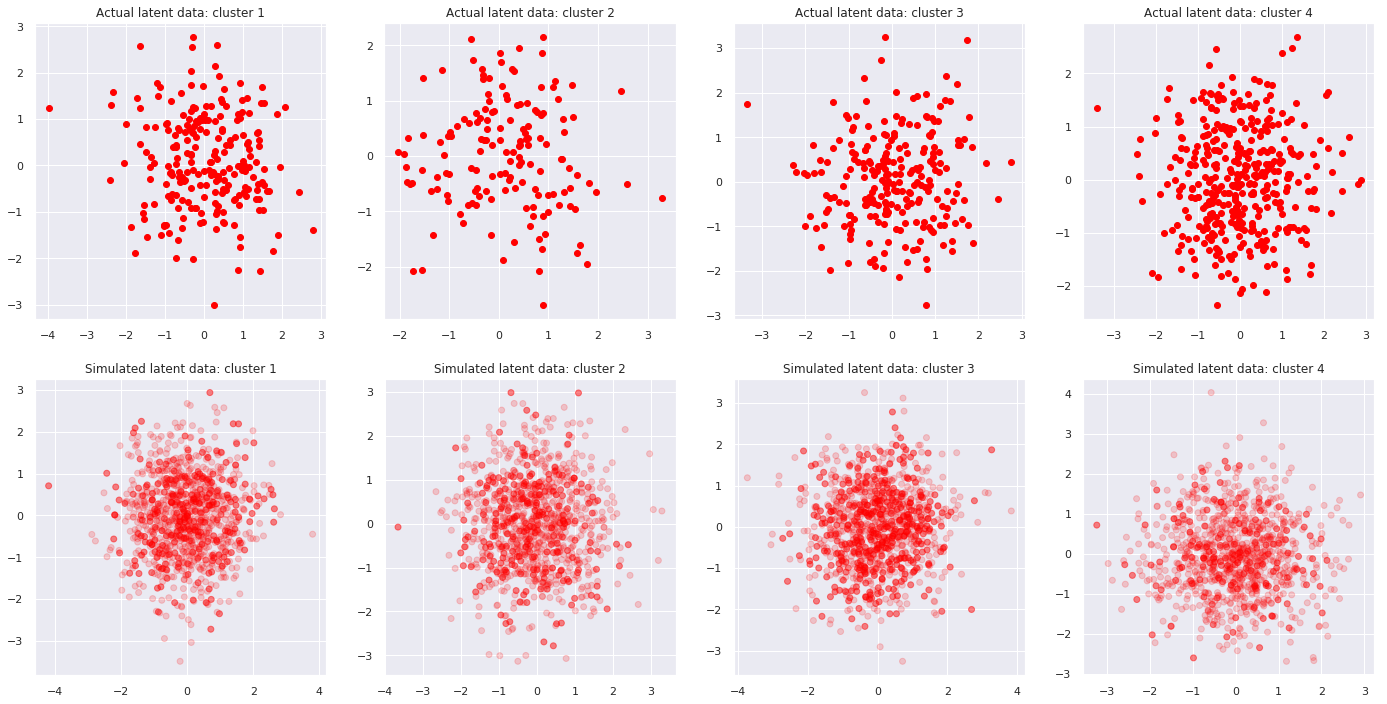

Cluster 0:
Real sample mean:  [0.03751456 0.09405701]
Simulated (weighted) mean:  [ 0.00171791 -0.02264158]
Real sample std. dev.:  [1.01194938 1.02305363]
Simulated (weighted) std. dev.:  [1.0101567  0.95988465]

Cluster 1:
Real sample mean:  [0.13378982 0.0150893 ]
Simulated (weighted) mean:  [-0.08926199 -0.03099385]
Real sample std. dev.:  [0.99354433 0.97816895]
Simulated (weighted) std. dev.:  [0.95892801 1.03040793]

Cluster 2:
Real sample mean:  [0.04512333 0.04745165]
Simulated (weighted) mean:  [ 0.00829521 -0.03190475]
Real sample std. dev.:  [0.97969652 1.02785064]
Simulated (weighted) std. dev.:  [0.99628965 0.95819905]

Cluster 3:
Real sample mean:  [-0.019235    0.01542565]
Simulated (weighted) mean:  [-0.03388438 -0.02876768]
Real sample std. dev.:  [0.96450344 0.96435297]
Simulated (weighted) std. dev.:  [1.00198299 0.97136781]



In [233]:
sns.set()
vis_threshold = 0.001

fig = plt.figure(figsize=(6*K,12))
for k in range(K):
    ax = fig.add_subplot(2,K,k+1)
    ax.scatter(z[k][0,np.array(ind)==k],z[k][1,np.array(ind)==k], c='red')
    ax.set_title('Actual latent data: cluster '+str(k+1))
    
for k in range(K):
    ax = fig.add_subplot(2,K,K+k+1)
    plotz = z_sim[k][:,clusters_norm[:,k]>vis_threshold]
    rgba_colors = np.zeros((sum(clusters_norm[:,k]>vis_threshold),4))
    rgba_colors[:,0] = 1.0
    rgba_colors[:, 3] = clusters_norm[:,k][clusters_norm[:,k]>vis_threshold]
    ax.scatter(plotz[0,:],plotz[1,:], c=rgba_colors)
    ax.set_title('Simulated latent data: cluster '+str(k+1))
    
plt.show()

for k in range(K):
    weights = clusters_norm[:,k]
    zbark = z_sim[k]
    print('Cluster '+str(k)+':')
    print('Real sample mean: ', np.mean(z[k][:,np.array(ind)==k],axis=1))
    weigh_mu_sim = np.sum(zbark*weights,axis=1)/sum(weights)
    print('Simulated (weighted) mean: ', weigh_mu_sim)
    print('Real sample std. dev.: ',np.std(z[k][:,np.array(ind)==k],axis=1))
    M = sum(clusters[:,k]>0.0)
    print('Simulated (weighted) std. dev.: ', np.sqrt(np.sum(np.square(zbark.T-weigh_mu_sim).T*weights,axis=1)/(sum(weights)*((M-1)/M))))
    print()

All clusters seem to be separated accurately, although it is unsure if the latent data is matched up with its correct corresponding estimate.